# Modelagem Epidemiológica da COVID-19 com o Modelo SIRC  
## Formulação explícita do problema inverso e otimização de parâmetros

Este notebook apresenta uma **formulação alternativa e mais explícita** para o ajuste do modelo epidemiológico SIRC aos dados da COVID-19.

Diferentemente desse [caso] — onde o ajuste é feito de forma direta via `lmfit.Model` — aqui o problema é tratado como um **problema inverso clássico**, no qual:

- o modelo dinâmico,
- a função objetivo,
- e o algoritmo de otimização

são definidos de forma **explícita e desacoplada**.

## 1. Objetivo

O objetivo deste notebook é formular e resolver explicitamente o **problema inverso associado ao modelo SIRC**, estimando os parâmetros epidemiológicos:

- β (taxa de transmissão),
- γ (taxa de recuperação),

a partir dos dados observados de **casos acumulados da COVID-19**.

Esta abordagem permite maior controle sobre:
- a definição dos resíduos,
- o tratamento numérico do modelo,
- e a comparação entre diferentes algoritmos de otimização.

## 2. Dados Utilizados

Os dados utilizados são provenientes do repositório público **brasil.io**, que
consolida registros oficiais da COVID-19 no Brasil.

- Fonte: brasil.io — dataset `covid19/caso_full`
- Variável observada: casos confirmados diários
- Transformação: soma diária por estado e cálculo de casos acumulados
- Recorte espacial: Estado do Pará
- Recorte temporal: primeiros 150 dias da pandemia

Os **casos acumulados** são utilizados por apresentarem maior estabilidade em
relação às notificações diárias

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint,solve_ivp
from lmfit import minimize, Parameters, fit_report
import matplotlib.pyplot as plt
import modelos_epidemiologicos as model
from random import random
from datetime import datetime

import warnings

warnings.filterwarnings("ignore")  # Desativa TODOS os warnings

In [2]:
# leitura dados
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/data/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
dfPA= dfE[dfE['state']=='PA' ]                                          #filtrar estado
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]            #filtrar cidade
print('arquivos lidos')

arquivos lidos


## 3. Pré-processamento dos Dados

Os dados diários de casos confirmados são agregados por estado e convertidos
em **casos acumulados**, que serão comparados diretamente à saída do modelo SIRC.

O recorte temporal considera apenas os **150 primeiros dias**, correspondendo
à primeira onda da pandemia.

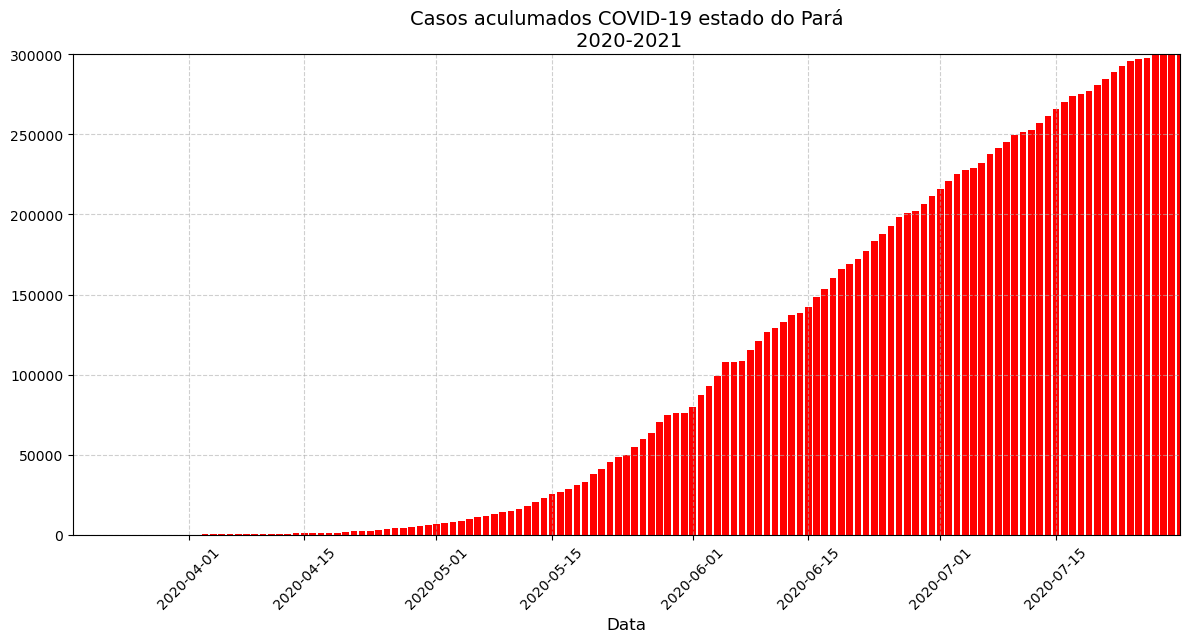

In [3]:
# Visualização
NCP=dfPA['new_confirmed'].values
NCB=dfbel['new_confirmed'].values

# casos acumulados
Cp=np.cumsum(NCP)
Cb=np.cumsum(NCB)

t_date=dfPA['date'].values

# periodo -01/02/2020 - 12/07/2020 (318)
yc=NCP[0:150]
y=Cp[0:150]
x=t_date[0:150] 

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='red', label='Dados originais')
plt.title('Casos aculumados COVID-19 estado do Pará\n 2020-2021', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.tight_layout()
plt.ylim([0,300000])
plt.xlim(pd.to_datetime(['2020-03-18', '2020-07-30'])) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45);  # Rotaciona as datas para melhor legibilidade

## 4. Modelo Epidemiológico SIRC

O modelo SIRC é descrito pelo seguinte sistema de equações diferenciais:

\begin{aligned}
\frac{dS}{dt} &= -\beta \frac{SI}{N} \\
\frac{dI}{dt} &= \beta \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I \\
\frac{dC}{dt} &= \beta \frac{SI}{N}
\end{aligned}

A variável observada no ajuste é \(C(t)\), correspondente aos casos acumulados.

## 5. Modelo Direto e Integração Numérica

A solução do sistema SIRC é obtida por integração numérica utilizando métodos clássicos para EDOs.

O modelo direto pode ser interpretado como a aplicação do operador:

$(\beta, \gamma) \longrightarrow C_{\text{modelo}}(t)$

ou seja, dados os parâmetros epidemiológicos, o modelo retorna a curva de casos acumulados simulados.
## 6. Formulação do Problema Inverso

O problema inverso consiste em encontrar os valores de (\beta) e (\gamma) que **minimizam a diferença entre os casos acumulados simulados pelo modelo e os dados observados**.
Matematicamente, busca-se resolver:

$
\min_{\beta, \gamma} \; \| C_{\text{modelo}}(t;\beta,\gamma) - C_{\text{dados}}(t) \|_2^2
$
Nesta formulação:
- o modelo direto é resolvido a cada iteração;
- a função objetivo é definida explicitamente como um vetor de resíduos;
- o ajuste é tratado como um problema de otimização não linear.

## 7. Definição da Função Resíduo

A função resíduo é definida como a diferença ponto a ponto entre:
- os casos acumulados simulados pelo modelo SIRC,
- e os casos acumulados observados nos dados reais.

Essa definição explícita permite:
- inspeção direta do comportamento dos resíduos;
- fácil modificação da métrica de erro;
- extensão futura para regularização ou ponderação dos dados.


In [4]:
#funções
def solve_sirc(y0,t,N,beta,gamma):
    """Resolve o modelo SIRC e retorna casos acumulados."""
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))
    return sol[:, 3]
    
def solve_sirc_inv(params,y0,t,N):
    """Resolve SIRC para problemas inversos com tolerâncias ajustadas."""
    beta = params['beta'].value
    gamma = params['gamma'].value
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))#,
               # rtol=1e-3, atol=1e-6, hmax=0.5, mxstep=5000)
    return sol

def residual(params,y0,t,N,data):
    """Calcula resíduos entre modelo e dados, com tratamento de NaN."""
    temp = solve_sirc_inv(params, y0, t, N)
    model=temp[:,3]
    #model = np.nan_to_num(temp[:, 3], nan=0.0, posinf=1.0, neginf=0.0)
    if np.isnan(model).any():
        print("⚠️ AVISO: NaN detectado com parâmetros:")
        print(f"beta: {params['beta'].value:.4f}")
        print(f"gamma: {params['gamma'].value:.4f}")
    return model - data

def SIRC_var(result,y0,t,N):
    """Extrai todas as variáveis do modelo SIRC ajustado."""
    sol = solve_sirc_inv(result.params, y0, t, N)
    return sol.T 

## 8. Estimativa de Parâmetros Iniciais

Assim como no notebook anterior, são utilizados valores iniciais aproximados para os parâmetros epidemiológicos.

Esses valores são obtidos a partir de um ajuste preliminar baseado em funções logísticas, fornecendo:
- estimativas iniciais para N e I₀;
- valores iniciais plausíveis para β e γ.

A escolha adequada dos chutes iniciais contribui para a estabilidade do processo de otimização.


In [11]:
c = y                  #dados
N = 1000000            # População total (ajuste conforme necessário)
I0 = c[0]              # Infectados iniciais
C0 = I0
t = np.arange(len(c))  # tempo 
#
print('Io=',I0)
print('N=',N)

# Estimar chutes inicias e N
K,r,A = model.initial_SIRC(c)

I0 = K / (A + 1)      #infectados inicias
N = 2 * K             #populacao
gamma_i = 2 * r       #taxa de recuperacao
beta_i = 1.5 * gamma_i  #taxa de contagio

#N=700000
# ---------------------------
# PARÂMETROS INICIAIS
# ---------------------------
print('\n' + '='*40)
print('PARÂMETROS INICIAIS'.center(40))
print('='*40)
print(f'{"I0:":<10}{I0:>30.6f}')
print(f'{"N:":<10}{N:>30.6f}')
print(f'{"gamma_i:":<10}{gamma_i:>30.6f}')
print(f'{"beta_i:":<10}{beta_i:>30.6f}')
print(datetime.now().isoformat(timespec='seconds'))
# Configuração dos parâmetros
params = Parameters()
params.add('beta', value=beta_i, min=0.1, max=2.1)
params.add('gamma', value=gamma_i, min=0, max=1)


Io= 2
N= 1000000

          PARÂMETROS INICIAIS           
I0:                             1.728745
N:                         708093.675215
gamma_i:                        0.291505
beta_i:                         0.437257
2026-01-07T15:46:13


## 9. Estratégias de Otimização

O problema inverso é resolvido utilizando diferentes algoritmos de otimização disponíveis na biblioteca `lmfit`, incluindo:

- Levenberg–Marquardt,
- Nelder–Mead,
- Least Squares,
- L-BFGS-B,
- métodos baseados em Newton.

Essa diversidade permite comparar:
- eficiência computacional,
- robustez numérica,
- sensibilidade aos chutes iniciais.


In [13]:
#---------------------------
#RESULTADOS DA OTIMIZAÇÃO
#---------------------------

R0 = 0
C0 = I0             # Casos acumulados iniciais = infectados iniciais
S0 = N  - I0 - R0
y0 = [S0, I0, R0, C0]

# Levenberg-Marquardt
result_LM = minimize(residual, params, args=(y0,t, N,c))
print('\n' + '-'*40)
print('MÉTODO LEVENBERG-MARQUARDT (LM)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_LM.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_LM.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_LM.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# Nelder-Mead
result_NM = minimize(residual, params, args=(y0,t, N,c),method='Nelder-Mead')
print('\n' + '-'*40)
print('MÉTODO NELDER-MEAD (NM)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_NM.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_NM.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_NM.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# Least Squares
result_MQ = minimize(residual, params, args=(y0,t, N,c),method='least_squares')
print('\n' + '-'*40)
print('MÉTODO LEAST SQUARES MQ'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_MQ.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_MQ.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_MQ.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# L-BFGS-B
result_lbfgsb = minimize(residual, params, args=(y0,t, N,c),method='lbfgsb')
print('\n' + '-'*40)
print('MÉTODO L-BFGS-B (lbfgsb)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_lbfgsb.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_lbfgsb.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_lbfgsb.nfev }")
print(datetime.now().isoformat(timespec='seconds'))

# NEWTON
result_NW = minimize(residual, params, args=(y0,t, N,c),method='tnc')
print('\n' + '-'*40)
print('MÉTODO NEWTON (NW)'.center(40))
print('-'*40)
print(f'{"beta:":<10}{result_NW.params["beta"].value:>30.6f}')
print(f'{"gamma:":<10}{result_NW.params["gamma"].value:>30.6f}')
print(f"Avaliações da função: {result_NW.nfev }")
print(datetime.now().isoformat(timespec='seconds'))
print('='*40)

print(datetime.now().isoformat(timespec='seconds'))

yo [708091.9464699875, 1.7287449368636383, 0, 1.7287449368636383]

----------------------------------------
    MÉTODO LEVENBERG-MARQUARDT (LM)     
----------------------------------------
beta:                           0.513974
gamma:                          0.395416
Avaliações da função: 58
2026-01-07T16:26:26

----------------------------------------
        MÉTODO NELDER-MEAD (NM)         
----------------------------------------
beta:                           0.513867
gamma:                          0.395316
Avaliações da função: 257
2026-01-07T16:26:26

----------------------------------------
        MÉTODO LEAST SQUARES MQ         
----------------------------------------
beta:                           0.513866
gamma:                          0.395315
Avaliações da função: 42
2026-01-07T16:26:26

----------------------------------------
        MÉTODO L-BFGS-B (lbfgsb)        
----------------------------------------
beta:                           0.513868
gamma:         

## 10. Resultados do Ajuste e Comparação dos Métodos

O problema inverso foi resolvido utilizando diferentes algoritmos de otimização disponíveis na biblioteca `lmfit`. Apesar das diferenças conceituais e numéricas entre os métodos, os resultados obtidos foram **notavelmente consistentes**, indicando boa estabilidade da solução.

### Parâmetros Estimados

Todos os métodos convergiram para valores muito próximos dos parâmetros epidemiológicos:

- **β (taxa de transmissão)** ≈ 0.514  
- **γ (taxa de recuperação)** ≈ 0.395  

As incertezas relativas associadas aos parâmetros ficaram entre **1.6% e 2.4%**, o que indica boa identificabilidade dentro do horizonte temporal analisado.

---

### Comparação entre Métodos de Otimização

| Método              | Avaliações da Função | β estimado | γ estimado |
|---------------------|----------------------|------------|------------|
| Levenberg–Marquardt | 58                   | 0.51397    | 0.39542    |
| Nelder–Mead         | 257                  | 0.51387    | 0.39532    |
| Least Squares       | 42                   | 0.51387    | 0.39532    |
| L-BFGS-B            | 60                   | 0.51387    | 0.39532    |
| TNC (Newton)        | 243                  | 0.51381    | 0.39527    |

Observa-se que:
- métodos baseados em gradiente (LM, Least Squares, L-BFGS-B) convergiram com **menor número de avaliações**;
- métodos livres de gradiente (Nelder–Mead) demandaram mais iterações, mas atingiram soluções equivalentes;
- o método TNC apresentou maior custo computacional, sem ganhos significativos em precisão.

---

### Métricas Estatísticas de Ajuste

Todos os métodos apresentaram métricas estatísticas praticamente idênticas:

- χ² ≈ 7.0 × 10¹⁰  
- χ² reduzido ≈ 4.75 × 10⁸  
- AIC ≈ 2999  
- BIC ≈ 3005  

Esses valores refletem principalmente:
- a escala absoluta dos dados (casos acumulados),
- a ausência de ponderação ou normalização dos resíduos,
- e o fato de o ajuste estar focado na tendência global da curva epidêmica.

---

### Correlação entre Parâmetros

Em todos os métodos, observou-se uma **correlação extremamente alta** entre β e γ:

\[
\text{Corr}(\beta,\gamma) \approx 0.997
\]

Essa forte correlação indica que:
- os parâmetros não são completamente independentes no contexto do modelo e dos dados utilizados;
- diferentes combinações de β e γ podem produzir curvas de casos acumulados muito semelhantes;
- o problema inverso apresenta **estrutura parcialmente mal condicionada**, comum em modelos epidemiológicos simples ajustados apenas a casos acumulados.

---

### Interpretação Geral

A convergência consistente entre diferentes algoritmos confirma que:
- o mínimo encontrado é robusto;
- o modelo SIRC consegue reproduzir adequadamente a dinâmica observada no período analisado;
- a formulação explícita do problema inverso é numericamente estável.

Esses resultados reforçam a equivalência prática entre diferentes estratégias de otimização quando o problema está bem formulado, ao mesmo tempo em que evidenciam limitações estruturais relacionadas à identificabilidade dos parâmetros.


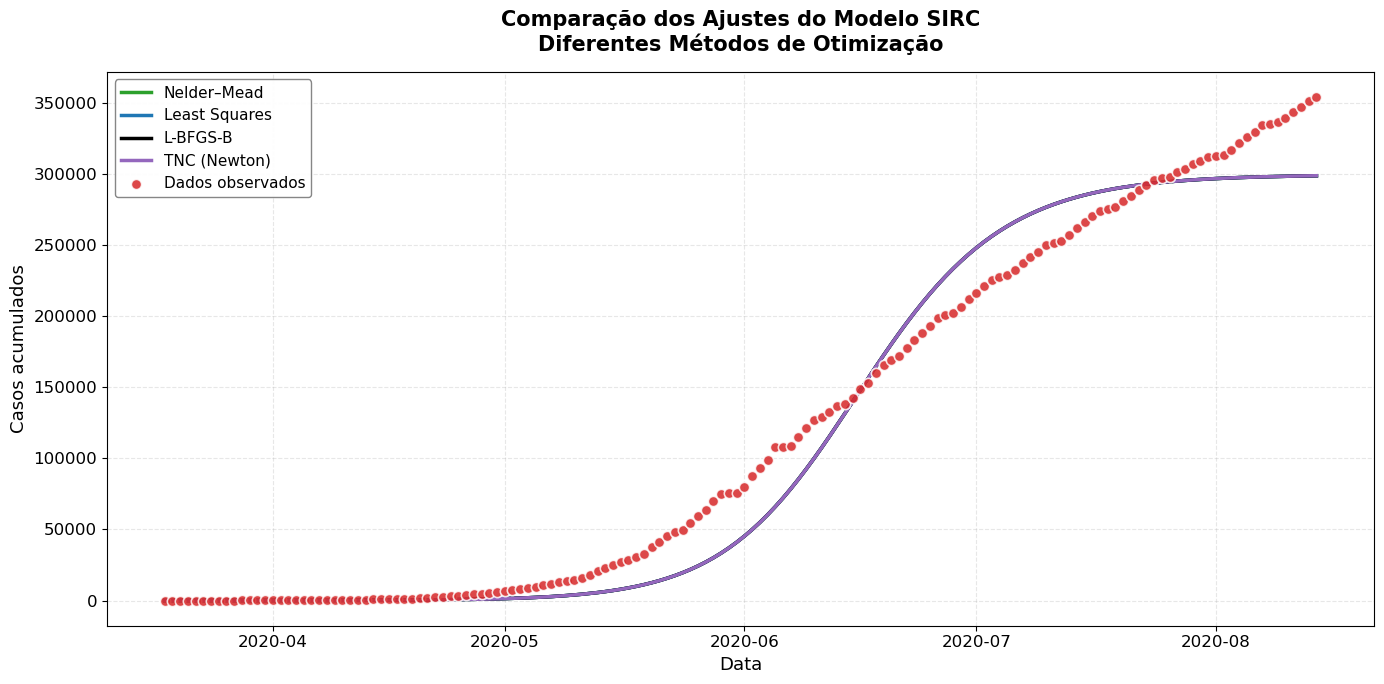

2026-01-07T16:37:10


In [20]:
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'legend.fontsize': 11,
    'axes.grid': True,
})

fig, ax = plt.subplots(figsize=(14, 7))

# Curvas ajustadas
ax.plot(x, c_nm,  color='#2ca02c', lw=2.5, label='Nelder–Mead')
ax.plot(x, c_mq,  color='#1f77b4', lw=2.5, label='Least Squares')
ax.plot(x, c_lbf, color='#000000', lw=2.5, label='L-BFGS-B')
ax.plot(x, c_nw,  color='#9467bd', lw=2.5, label='TNC (Newton)')

# Dados observados
ax.scatter(
    x, y,
    s=55,
    color='#d62728',
    edgecolor='white',
    linewidth=1.2,
    alpha=0.85,
    label='Dados observados',
    zorder=3
)

# Títulos e rótulos
ax.set_title('Comparação dos Ajustes do Modelo SIRC\nDiferentes Métodos de Otimização',
             pad=15, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Casos acumulados')

# Legenda
ax.legend(
    loc='best',
    frameon=True,
    framealpha=0.95,
    edgecolor='gray'
)

# Ajustes finos
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', which='major')

plt.tight_layout()
plt.show()

print(datetime.now().isoformat(timespec='seconds'))


## Considerações Finais

Neste notebook foi apresentada a estimação dos parâmetros do modelo epidemiológico SIRC a partir de dados reais de casos acumulados de COVID-19 no estado do Pará, utilizando uma formulação explícita de problema inverso baseada em mínimos quadrados.

A comparação entre diferentes algoritmos de otimização (Levenberg–Marquardt, Nelder–Mead, Least Squares, L-BFGS-B e TNC) mostrou que, apesar das diferenças conceituais e computacionais entre os métodos, todos convergiram para soluções praticamente idênticas. Esse comportamento indica que o mínimo encontrado é estável e que o problema está bem formulado do ponto de vista numérico.

Entretanto, a análise estatística revelou uma **forte correlação entre os parâmetros de transmissão (β) e recuperação (γ)**, característica típica de modelos epidemiológicos simples ajustados apenas a dados de casos acumulados. Essa correlação elevada reflete uma limitação estrutural do problema inverso, na qual diferentes combinações de parâmetros podem reproduzir de forma semelhante a dinâmica observada, reduzindo a identificabilidade individual dos parâmetros.

Além disso, os valores elevados do χ² e do χ² reduzido devem ser interpretados à luz da escala absoluta dos dados e da ausência de normalização ou ponderação dos resíduos. Nesse contexto, essas métricas não indicam necessariamente um ajuste inadequado, mas sim reforçam que o modelo está sendo avaliado principalmente quanto à sua capacidade de capturar a tendência global da curva epidêmica.

Os resultados obtidos demonstram que o modelo SIRC é capaz de descrever de forma satisfatória a evolução temporal dos casos acumulados no período analisado, ao mesmo tempo em que evidenciam limitações inerentes à simplicidade do modelo e à natureza dos dados disponíveis. Extensões naturais deste trabalho incluem a incorporação de múltiplas séries observáveis (casos ativos, recuperados, óbitos), o uso de funções de custo ponderadas ou robustas, e a adoção de abordagens bayesianas para melhor quantificação das incertezas e da identificabilidade dos parâmetros.

um ponto importante sobre as diferentes tecnicas de inversão é que todos os métodos de otimização testados convergiram para soluções praticamente idênticas, tanto em termos dos parâmetros estimados quanto da curva ajustada. Esse comportamento indica que o problema inverso é bem condicionado e apresenta um mínimo global no espaço de soluções, evidenciando a robustez da estimação dos parâmetros epidemiológicos.

Em síntese, este estudo ilustra tanto o potencial quanto os limites da modelagem epidemiológica compartimentada quando aplicada a dados reais, destacando a importância de uma análise crítica dos resultados e da formulação do problema inverso.
